# Load Model

In [1]:
%load_ext autoreload
%autoreload 2

from transformers import AutoTokenizer, AutoModel
from autoLRP.LRPBase import LRPTensor
from autoLRP.LRPModel import LRPModel

# Setup device
device = "mps"

# Load pre-trained model and tokenizer
model_name = "sentence-transformers/stsb-bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

# write a i love roses
text = "Drinking a coffee outside a beautiful view of the mountains"    
inputs = tokenizer(text, return_tensors="pt")
input_ids = inputs["input_ids"].to(device)
fe = model.embeddings.word_embeddings(input_ids)
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())


/opt/miniconda3/envs/waleed/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Wrap it with LRP

1. You should wrap the input with `LRPTensor` ( an extension to `torch.Tensor` ) to keep track of relevance during `lrp_backpass()`
2. Wrap your model with `LRPModel` to inherit the `LRP` utilities.

In [2]:

fe = LRPTensor(fe).to(device) # Wrap the embeddings in LRPTensor
lrp_model = LRPModel(model).to(device)

# Forward pass
he = lrp_model(inputs_embeds=fe).last_hidden_state.mean(dim=1)


TypeError: LRPBertSelfAttention.__init__() missing 1 required positional argument: 'base_self_attention'

# Run `lrp_backpass()` on the output.

In [ ]:
lrp_model.lrp_backpass(he)

100%|██████████| 768/768 [00:15<00:00, 49.71it/s]


# Extract relevance from input.

`LRPTensor.relevance_scores` is of the same shape as the original `Tensor`. It is up to you how you want to manuplate it.

In this case we want to accumlate relevance per `token`.

In [ ]:
relevance_scores = fe.relevance_scores.sum(dim=-1).squeeze().detach().cpu().numpy()

# Visalize with respect to your input.

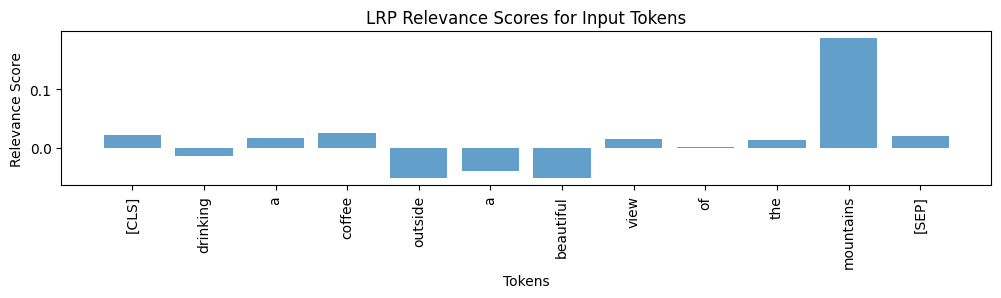

In [ ]:
import matplotlib.pyplot as plt

# Plotting relevance scores
plt.figure(figsize=(12, 2))
plt.bar(range(len(tokens)), relevance_scores, align='center', alpha=0.7)
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.xlabel('Tokens')
plt.ylabel('Relevance Score')
plt.title('LRP Relevance Scores for Input Tokens')
plt.show()
